**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

## Movielens

In [0]:
!pip3 install fastai==0.7.0
!pip install torchtext==0.2.3

    100% |████████████████████████████████| 122kB 3.7MB/s 
    100% |████████████████████████████████| 3.6MB 1.2MB/s 
    100% |████████████████████████████████| 496.4MB 34kB/s 
    100% |████████████████████████████████| 1.5MB 7.0MB/s 
    100% |████████████████████████████████| 12.4MB 2.5MB/s 
    100% |████████████████████████████████| 61kB 19.0MB/s 
    100% |████████████████████████████████| 81kB 21.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built feather-format bcolz
mizani 0.5.3 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
plotnine 0.5.1 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [0]:
!wget  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip && unzip -qq ml-latest-small.zip -d data/

--2019-03-16 06:29:41--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.06MB/s    in 0.2s    

2019-03-16 06:29:41 (4.06 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [0]:
!ls data

ml-latest-small


In [0]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [0]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Just for display purposes, let's read in the movie names too.

In [0]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [0]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [0]:
## Initialize the cross-validation indices

val_idxs = get_cv_idxs(len(ratings))
wd=2e-4 #weight decay => L2 Regularization
n_factors = 50 #number of embeddings (dimensionality)

In [0]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam) 
#(size of embedding matrix, validation set index, batch size, optimizer)

In [0]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   
    0      0.764601   0.774571  
    1      0.725551   0.754425  
    2      0.572423   0.73813   



[array([0.73813])]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [0]:
#math.sqrt(0.776)
math.sqrt(0.73813)

0.8591449237468612

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [0]:
preds = learn.predict()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


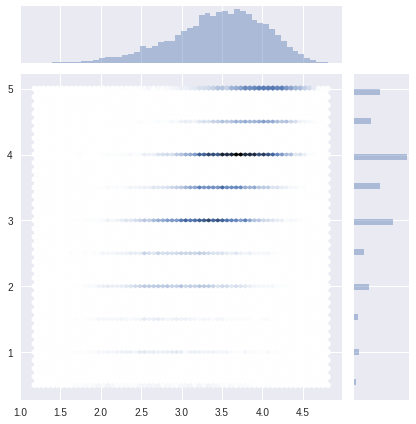

In [0]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [0]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [0]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(610, 50)
  (i): Embedding(9724, 50)
  (ub): Embedding(610, 1)
  (ib): Embedding(9724, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [0]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [0]:
movie_bias

array([[ 0.92273],
       [ 1.26769],
       [ 0.98932],
       ...,
       [-0.28849],
       [ 0.04121],
       [ 0.09755]], dtype=float32)

In [0]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [0]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.7151751, 'Catwoman (2004)'),
 (-0.7138031, 'Stuart Saves His Family (1995)'),
 (-0.7043003, 'Karate Kid, Part III, The (1989)'),
 (-0.69571793, 'Grease 2 (1982)'),
 (-0.6937187, 'Spice World (1997)'),
 (-0.68693805, 'Speed 2: Cruise Control (1997)'),
 (-0.6772697, 'Anaconda (1997)'),
 (-0.64696187, 'Godzilla (1998)'),
 (-0.6250226, 'Problem Child (1990)'),
 (-0.6224436, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (-0.61763656, 'Super Mario Bros. (1993)'),
 (-0.61402756, 'Scary Movie 3 (2003)'),
 (-0.61402524, 'Battlefield Earth (2000)'),
 (-0.60438955, 'Jason X (2002)'),
 (-0.58715266, 'Rocky V (1990)')]

In [0]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.7151751, 'Catwoman (2004)'),
 (-0.7138031, 'Stuart Saves His Family (1995)'),
 (-0.7043003, 'Karate Kid, Part III, The (1989)'),
 (-0.69571793, 'Grease 2 (1982)'),
 (-0.6937187, 'Spice World (1997)'),
 (-0.68693805, 'Speed 2: Cruise Control (1997)'),
 (-0.6772697, 'Anaconda (1997)'),
 (-0.64696187, 'Godzilla (1998)'),
 (-0.6250226, 'Problem Child (1990)'),
 (-0.6224436, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (-0.61763656, 'Super Mario Bros. (1993)'),
 (-0.61402756, 'Scary Movie 3 (2003)'),
 (-0.61402524, 'Battlefield Earth (2000)'),
 (-0.60438955, 'Jason X (2002)'),
 (-0.58715266, 'Rocky V (1990)')]

In [0]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.2676948, 'Shawshank Redemption, The (1994)'),
 (0.9893225, 'Pulp Fiction (1994)'),
 (0.9255441, 'Usual Suspects, The (1995)'),
 (0.9227303, 'Forrest Gump (1994)'),
 (0.9200083, 'Casablanca (1942)'),
 (0.9125267, "Schindler's List (1993)"),
 (0.8935245, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.8899636,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.8741707, 'Goodfellas (1990)'),
 (0.87324774, 'Princess Bride, The (1987)'),
 (0.86750007, 'Godfather, The (1972)'),
 (0.8616126, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.827309, 'Dark Knight, The (2008)'),
 (0.82346565, 'American History X (1998)'),
 (0.8180833, 'Rear Window (1954)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [0]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [0]:
movie_pca.shape

(3, 3000)

In [0]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07255862, 'Twister (1996)'),
 (0.06297031, 'Congo (1995)'),
 (0.062103037, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.05859249, 'Jason X (2002)'),
 (0.054533508, 'Net, The (1995)'),
 (0.05411097, 'Broken Arrow (1996)'),
 (0.051157694, 'Lara Croft: Tomb Raider (2001)'),
 (0.050321445, 'Striptease (1996)'),
 (0.05011959, 'The Scorpion King (2002)'),
 (0.049996156, 'Speed (1994)')]

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.08854448, 'Pulp Fiction (1994)'),
 (-0.08414066, 'Godfather, The (1972)'),
 (-0.08020972, 'Fight Club (1999)'),
 (-0.075764135, 'Big Lebowski, The (1998)'),
 (-0.07275014, 'Memento (2000)'),
 (-0.069271505, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (-0.0684462, 'Requiem for a Dream (2000)'),
 (-0.0671694, 'Kill Bill: Vol. 1 (2003)'),
 (-0.06601735, 'Reservoir Dogs (1992)'),
 (-0.06601381, 'Godfather: Part II, The (1974)')]

In [0]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.061465386, 'Judge Dredd (1995)'),
 (0.05120634, 'Showgirls (1995)'),
 (0.04935167, 'M (1931)'),
 (0.048841543, 'Mars Attacks! (1996)'),
 (0.047456052, 'Bad Lieutenant (1992)'),
 (0.046407785, 'Deer Hunter, The (1978)'),
 (0.042575117, 'The Artist (2011)'),
 (0.042212263, "Boys Don't Cry (1999)"),
 (0.041945588, 'Battlefield Earth (2000)'),
 (0.04139233, "Pee-wee's Big Adventure (1985)")]

In [0]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10998381, 'Back to the Future (1985)'),
 (-0.09438555, 'Matrix, The (1999)'),
 (-0.09350062, 'Forrest Gump (1994)'),
 (-0.09289263, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (-0.08673364, 'Spider-Man (2002)'),
 (-0.08574952, 'Braveheart (1995)'),
 (-0.08144635, 'Star Trek II: The Wrath of Khan (1982)'),
 (-0.079633705, 'Jurassic Park (1993)'),
 (-0.07543197,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.07461825, 'Saving Private Ryan (1998)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

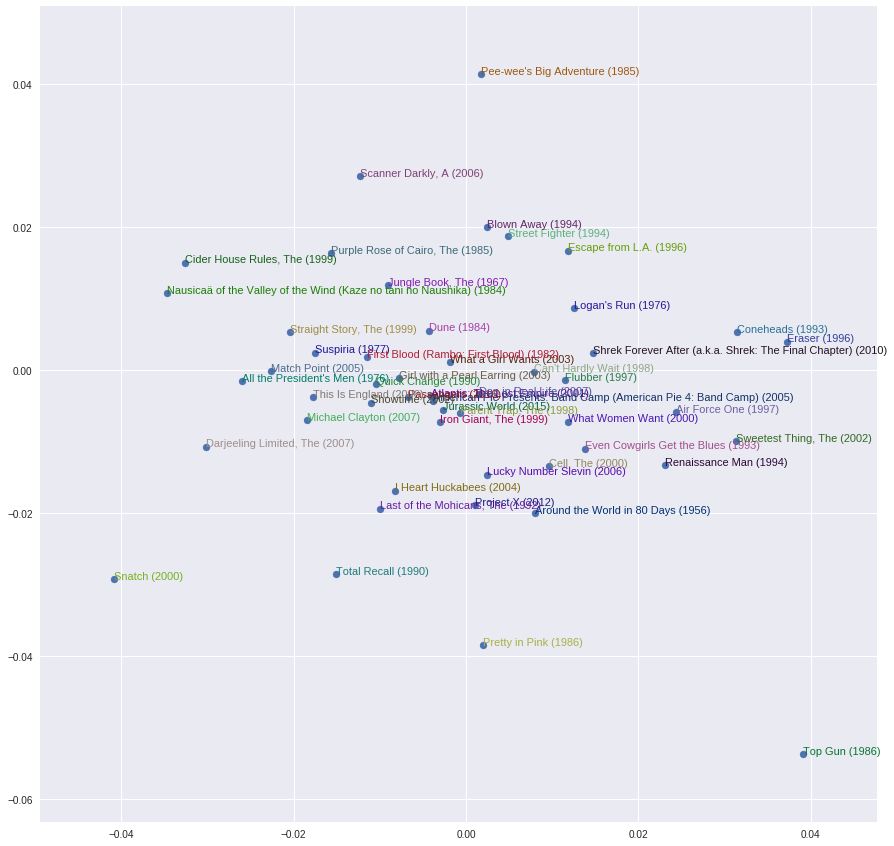

In [0]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [0]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [0]:
a*b


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [0]:
(a*b).sum(1)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [0]:
class DotProduct(nn.Module):
    def forward(self, u, m): 
      return (u*m).sum(1)

In [0]:
model=DotProduct()

In [0]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

### Dot product model

In [0]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)} #mapping unique user to contiguous index
ratings.userId = ratings.userId.apply(lambda x: user2idx[x]) 
#lambda creates a function on the fly => Fancy legwork

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

**Keiming He Initialization**

Set weights to a normal distribution with standard deviation inversely proportional to the number of factors (i.e embeddings)

- Variable vs. Tensor: They are the same except auto - differentiation can be done on a Pytorch variable. 
 To get the tensor from a variable, you call it's data attribute


In [0]:
# Custom Pytorch Dot Product

class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        #Randomly initialized embedding weight matrices
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1).view(-1, 1)

In [0]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [0]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64) #fast.ai ish

In [0]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9) #optimizer

In [0]:
 fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      1.596783   1.600137  
    1      1.047582   1.294406  
    2      0.897011   1.2211    



[array([1.2211])]

In [0]:
set_lrs(opt, 0.01)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.661681   1.15017   
    1      0.682408   1.139056  
    2      0.6366     1.133365  



[array([1.13337])]

### Bias

In [0]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [0]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze() #Pytorch way of broadcasting
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating #F => Pytorch module Functional - #Function Squishing
        return res.view(-1, 1)

In [0]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.799639   0.814305  
    1      0.751485   0.796059  
    2      0.72745    0.790315  



[array([0.79031])]

In [0]:
set_lrs(opt, 1e-2)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.727458   0.781197  
    1      0.701806   0.779633  
    2      0.706345   0.779463  



[array([0.77946])]

### Mini net

In [0]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [0]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.818438   0.791246  
    1      0.776644   0.772099  
    2      0.75678    0.763618  



[array([0.76362])]

In [0]:
set_lrs(opt, 1e-3)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.753698   0.766655  
    1      0.71788    0.769193  
    2      0.705379   0.771218  



[array([0.77122])]